### Fantasy Fumball: Using Machine Learning to Predict the Rank of Offensive Players in the NFL for Fantasy Football Drafting  

#### Introduction
Fantasy Sports is an industry estimated at over $7B per year (https://qz.com/1068534/how-the-7-billion-us-fantasy-football-industry-makes-its-money-in-2017/). It spans a host of sports and has spawned leagues and even a TV show (The League https://en.wikipedia.org/wiki/The_League) revolving around the players. My project specifically focused on fantasy football and selecting (aka drafting) the players that would be most likely to create a winning team. I set out to discover if it was possible to predict the rank of offensive players in the NFL for fantasy sports based on their statistics across the entire season.  
The objective of my project is to come up with a way to rank players so I can increase my probability of picking great starters and finally win my league.  

#### Fantasy Football Drafting and Assumptions  
Fantasy football is rife with stats for a data scientist. Most aspects of the game are quantified in discrete terms. Additionally, player rank is a continuous variable that we can test for and predict. I opted to only study offensive players that played positions that could be drafted onto my fantasy team. In this case, that meant evaluating the following positions: Quarterback (QB), Running back (RB), Wide Receiver (WR), Tight End (TE), and Kicker (K).  
As a note, due to time constraints, I opted to ignore defensive positions for this project. The data I pulled was for individual players and we typically draft an entire team defense. For future work, I would like to aggregate players of a team's defense and pull a full team score across the season to further improve my rank predictions.  
I also ignored Points-Per-Reception (PPR) scoring in my calculations since my league does not play by that rule. Future work would also include an option to toggle PPR on or off as it can make a difference in drafting.

#### Data Collection  
My data is pulled from https://github.com/BurntSushi/nflgame, an API to read and retrieve NFL Game Center JSON Data. I will be using 2016 full season stats for my feature set. I also pulled the top 300 player rank, as ranked by ESPN, for my response vector. 

In [1]:
# read the data into a DataFrame named nfl16
import pandas as pd
path = '../GA_Class_Project/'
url = path + 'season2016_wy.csv'
nfl16 = pd.read_csv(url, index_col = 0)
nfl16.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
A.Janovich,00-0032956,no,DEN,FB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,44.0,4.0,33.0,28.0,1.0,0.0,0.0,33.0
D.Booker,00-0032972,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,3.0,...,0.0,0.0,265.0,174.0,152.0,21.0,4.0,0.0,0.0,612.0
C.Anderson,00-0029854,no,DEN,RB,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,128.0,110.0,106.0,13.0,4.0,0.0,0.0,437.0
V.Green,00-0028142,no,DEN,TE,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Determine total number of players in dataframe
nfl16.shape
# 1573 players in this list with 59 attributes

(1573, 59)

In [3]:
# Determine how many players would be eligible to be drafted based on open positions in a fantasy roster
nfl16.pos.value_counts()

WR     205
RB     146
DE     144
CB     129
TE     115
OLB     93
DT      90
DB      79
QB      71
LB      66
SS      52
ILB     44
FS      43
K       35
P       35
NT      25
OT      19
FB      18
MLB     16
C       16
OG      12
T        7
G        7
LS       6
SAF      3
Name: pos, dtype: int64

Since I was only interested in QB, RB, WR, TE, K, I created new DataFrames using only these positions. This step was not totally necessary but it did simplify my data nicely.

In [4]:
# Create new DataFrames using only QB, WR, RB, TE, K
nfl16_QB = nfl16.loc[nfl16.pos == 'QB']
nfl16_WR = nfl16.loc[nfl16.pos == 'WR']
nfl16_RB = nfl16.loc[nfl16.pos == 'RB']
nfl16_TE = nfl16.loc[nfl16.pos == 'TE']
nfl16_K = nfl16.loc[nfl16.pos == 'K']

In [5]:
# Concat the new DataFrames back together as "nfl16_off"
frames = [nfl16_QB, nfl16_WR, nfl16_RB, nfl16_TE, nfl16_K]
nfl16_off = pd.concat(frames)
nfl16_off.shape

(572, 59)

In [6]:
# Perform a Sanity Check to make sure the expected players are still there
nfl16_off.head()

,id,home,team,pos,defense_ast,defense_ffum,defense_int,defense_sk,defense_tkl,fumbles_lost,...,receiving_twopta,receiving_twoptm,receiving_yds,rushing_att,rushing_lng,rushing_lngtd,rushing_tds,rushing_twopta,rushing_twoptm,rushing_yds
name,,,,,,,,,,,,,,,,,,,,,
T.Siemian,00-0032156,no,DEN,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,28.0,42.0,0.0,0.0,1.0,0.0,57.0
C.Newton,00-0027939,no,CAR,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,90.0,162.0,14.0,5.0,1.0,1.0,359.0
M.Ryan,00-0026143,no,ATL,QB,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,35.0,94.0,0.0,0.0,1.0,0.0,117.0
J.Winston,00-0031503,no,TB,QB,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,52.0,121.0,7.0,1.0,1.0,0.0,168.0
J.Flacco,00-0026158,no,BAL,QB,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,22.0,55.0,8.0,2.0,0.0,0.0,53.0


#### Fantasy Football Scoring
Players earn points based on their stats. The goal of your draft is to amass the highest scoring players on to your team. A breakdown point totals is below (https://fantasydata.com/resources/fantasy-scoring-system.aspx):  

Offensive Players  
•	Passing Yards: 1 point per 25 yards 
•	Passing Touchdowns: 4 points  
•	Passing Interceptions: -2 points  
•	Rushing Yards: 1 point per 10 yards  
•	Rushing Touchdowns: 6 points  
•	Receptions: 1 points (only if using PPR scoring)  
•	Receiving Yards: 1 point per 10 yards  
•	Receiving Touchdowns: 6 points  
•	2-Point Conversions: 2 points  
•	Fumbles Lost: -2 points  
•	Fumble Recovered for a Touchdown: 6 points  
Kicking  
•	Point After Touchdown (PAT) Made: 1 point  
•	Field Goal (FG) Made (0-49 yards): 3 points  
•	FG Made (50+ yards): 5 points  

I used the above listed point values and mapped them to each player's statistics to come up with the total number of points a player would have scored across the season. Of note, a kicker's statistics are more single game specific than other player's statistics. For example, a long range field goal (50+ yards) earns an extra 2 points for the kicker. Since I pulled full season data, I did not have the yardage breakdown in an easy to determine format. Future work would include looping through kickers stats for each game to give them their proper bonus points. For now, I assumed all Field Goals made were worth 3 points.

In [7]:
# Determine column headers
nfl16_off.columns.values.tolist()

['id',
 'home',
 'team',
 'pos',
 'defense_ast',
 'defense_ffum',
 'defense_int',
 'defense_sk',
 'defense_tkl',
 'fumbles_lost',
 'fumbles_rcv',
 'fumbles_tot',
 'fumbles_trcv',
 'fumbles_yds',
 'kicking_fga',
 'kicking_fgm',
 'kicking_fgyds',
 'kicking_totpfg',
 'kicking_xpa',
 'kicking_xpb',
 'kicking_xpmade',
 'kicking_xpmissed',
 'kicking_xptot',
 'kickret_avg',
 'kickret_lng',
 'kickret_lngtd',
 'kickret_ret',
 'kickret_tds',
 'passing_att',
 'passing_cmp',
 'passing_ints',
 'passing_tds',
 'passing_twopta',
 'passing_twoptm',
 'passing_yds',
 'punting_avg',
 'punting_i20',
 'punting_lng',
 'punting_pts',
 'punting_yds',
 'puntret_avg',
 'puntret_lng',
 'puntret_lngtd',
 'puntret_ret',
 'puntret_tds',
 'receiving_lng',
 'receiving_lngtd',
 'receiving_rec',
 'receiving_tds',
 'receiving_twopta',
 'receiving_twoptm',
 'receiving_yds',
 'rushing_att',
 'rushing_lng',
 'rushing_lngtd',
 'rushing_tds',
 'rushing_twopta',
 'rushing_twoptm',
 'rushing_yds']

In [8]:
# Map player stats to points using list comprehensions
fumbles_lost_pts = [x * -2 for x in nfl16_off.fumbles_lost]
passing_yds_pts = [x / 25 for x in nfl16_off.passing_yds]
passing_tds_pts = [x * 4 for x in nfl16_off.passing_tds]
passing_ints_pts = [x * -2 for x in nfl16_off.passing_ints]
rushing_yds_pts = [x / 10 for x in nfl16_off.rushing_yds]
rushing_tds_pts = [x * 6 for x in nfl16_off.rushing_tds]
receiving_yds_pts = [x / 10 for x in nfl16_off.receiving_yds]
receiving_tds_pts = [x * 6 for x in nfl16_off.receiving_tds]
passing_twoptm_pts = [x * 2 for x in nfl16_off.passing_twoptm]
receiving_twoptm_pts = [x * 2 for x in nfl16_off.receiving_twoptm]
rushing_twoptm_pts = [x * 2 for x in nfl16_off.rushing_twoptm]
kicking_xpmade_pts = [x * 1 for x in nfl16_off.kicking_xpmade]
# For now, counting all field goals as 3 points for ease of data
# fgyds doesn't work across entire season
kicking_fgm_pts = [x * 3 for x in nfl16_off.kicking_fgm]

In [9]:
# create DataFrame for list of pts, give it the same index as before
nflpts = pd.DataFrame(list(zip(fumbles_lost_pts, passing_yds_pts, passing_tds_pts, passing_ints_pts, rushing_yds_pts, rushing_tds_pts, receiving_yds_pts, receiving_tds_pts, passing_twoptm_pts, receiving_twoptm_pts, rushing_twoptm_pts, kicking_xpmade_pts, kicking_fgm_pts)),
                      index = nfl16_off.index,
                      columns=['fumbles_lost_pts', 'passing_yds_pts', 'passing_tds_pts', 'passing_ints_pts', 'rushing_yds_pts', 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'passing_twoptm_pts', 'receiving_twoptm_pts', 'rushing_twoptm_pts', 'kicking_xpmade_pts', 'kicking_fgm_pts'])

type(nflpts)

pandas.core.frame.DataFrame

In [10]:
nflpts.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts
name,,,,,,,,,,,,,
T.Siemian,-4.0,136.08,72.0,-20.0,5.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
C.Newton,-4.0,140.36,76.0,-28.0,35.9,30.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN
M.Ryan,-4.0,197.76,152.0,-14.0,11.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN
J.Winston,-12.0,163.60,112.0,-36.0,16.8,6.0,NaN,NaN,6.0,NaN,0.0,NaN,NaN
J.Flacco,-6.0,172.68,80.0,-30.0,5.3,12.0,NaN,NaN,8.0,NaN,0.0,NaN,NaN


In [ ]:
# Defining function to sum total points using for loop
def point_totals():
    tot_pts = []
    for index, row in nflpts.iterrows():
        tot_pts.append((index, row.sum()))
    return tot_pts
        
point_totals()[0:5]

In [34]:
# summing total points as list comprehension
# totalpoints = [(index, row.sum()) for index, row in nflpts.iterrows()] #this will return a tuple
totalpoints = [row.sum() for index, row in nflpts.iterrows()]
totalpoints

[191.78,
 254.26000000000002,
 345.46,
 256.40000000000003,
 241.98000000000002,
 270.92,
 169.42000000000002,
 46.76,
 270.2,
 380.02,
 223.78000000000003,
 259.3,
 332.32,
 268.32,
 133.36,
 260.64,
 212.98,
 260.74,
 266.05999999999995,
 190.28,
 286.88,
 224.18000000000004,
 66.44,
 307.70000000000005,
 279.98,
 244.66,
 35.059999999999995,
 300.76,
 252.16,
 72.7,
 111.14,
 7.44,
 9.38,
 52.1,
 15.66,
 5.16,
 28.3,
 9.379999999999999,
 -0.1,
 220.88000000000002,
 79.1,
 16.520000000000003,
 77.0,
 7.9,
 0.3,
 28.38,
 33.92,
 10.18,
 258.56,
 7.9399999999999995,
 70.84,
 16.66,
 28.0,
 9.0,
 0.44,
 -1.56,
 -0.4799999999999998,
 32.26,
 -1.5199999999999998,
 -0.2,
 53.160000000000004,
 8.940000000000001,
 1.7,
 200.07999999999998,
 54.74,
 17.64,
 0.64,
 0.88,
 1.7399999999999998,
 6.0,
 -1.44,
 133.60000000000002,
 136.3,
 23.3,
 105.0,
 134.1,
 32.2,
 63.1,
 44.3,
 176.9,
 89.8,
 0.0,
 78.0,
 47.0,
 208.1,
 17.3,
 130.8,
 6.5,
 113.9,
 68.1,
 38.8,
 -2.0,
 67.9,
 55.0,
 16.5,
 15.

In [ ]:
nfl16_off.index

In [12]:
nflpts.describe()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts
count,252.000000,89.000000,89.000000,89.000000,297.000000,297.000000,447.000000,447.000000,89.000000,447.000000,297.000000,35.000000,35.000000
mean,-2.111111,58.773034,35.280899,-9.325843,18.584175,8.727273,28.990828,10.442953,0.808989,0.134228,0.094276,31.885714,72.771429
std,2.379267,70.275743,45.708809,11.500766,30.075698,16.680109,32.322706,13.941284,1.776593,0.568111,0.484072,11.485980,23.264573
min,-12.000000,0.000000,0.000000,-42.000000,-1.200000,0.000000,-1.600000,0.000000,0.000000,0.000000,0.000000,9.000000,24.000000
25%,-2.000000,0.880000,0.000000,-16.000000,0.700000,0.000000,4.600000,0.000000,0.000000,0.000000,0.000000,23.500000,57.000000
50%,-2.000000,18.120000,8.000000,-4.000000,4.400000,0.000000,15.400000,6.000000,0.000000,0.000000,0.000000,32.000000,78.000000
75%,-0.000000,137.040000,72.000000,-0.000000,20.900000,12.000000,42.850000,18.000000,2.000000,0.000000,0.000000,40.500000,88.500000
max,-0.000000,208.320000,160.000000,-0.000000,163.100000,108.000000,144.800000,84.000000,10.000000,4.000000,4.000000,56.000000,114.000000


#### Adding Response Vector to Features
The nflgame API only included player stats but not player rank. I retrieved a Top 300 Fantasy Football player list from ESPN's website and appended it here.

In [32]:
url = path + 'rank2016_wy.csv'
nflrank = pd.read_csv(url, index_col = 'name')
nflrank.pos.value_counts()

WR     103
RB      91
TE      34
QB      32
DST     22
K       18
Name: pos, dtype: int64

In [14]:
# I dropped position from nflrank since it was already encoded in my original data
nflrank = nflrank.drop('pos', 1)
nflrank.head()

,rank
name,
A.Brown,1
O.Beckham,2
A.Peterson,3
J.Jones,4
T.Gurley,5


In [15]:
print nfl16_off.shape
print nflrank.shape
print nflpts.shape

(572, 59)
(300, 1)
(572, 13)


In [39]:
# add totalpoints to nflpts DataFrame
type(totalpoints)
# totalpoints is a list

totalpointslist = pd.Series(totalpoints)
nflpts['totalpoints'] = totalpointslist.values
nflpts.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints
name,,,,,,,,,,,,,,
T.Siemian,-4.0,136.08,72.0,-20.0,5.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,191.78
C.Newton,-4.0,140.36,76.0,-28.0,35.9,30.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,254.26
M.Ryan,-4.0,197.76,152.0,-14.0,11.7,0.0,NaN,NaN,2.0,NaN,0.0,NaN,NaN,345.46
J.Winston,-12.0,163.60,112.0,-36.0,16.8,6.0,NaN,NaN,6.0,NaN,0.0,NaN,NaN,256.40
J.Flacco,-6.0,172.68,80.0,-30.0,5.3,12.0,NaN,NaN,8.0,NaN,0.0,NaN,NaN,241.98


In [40]:
# Add nflrank to nflpts
# Since my original data has more rows than the player ranks, I had to join the DataFrames rather than concatenate them.
nfl = nflpts.join(nflrank)
nfl.head()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints,rank,pos
name,,,,,,,,,,,,,,,,
A.Abdullah,NaN,NaN,NaN,NaN,10.1,0.0,5.7,6.0,NaN,0.0,0.0,NaN,NaN,21.8,75.0,RB
A.Benn,NaN,NaN,NaN,NaN,NaN,NaN,11.6,6.0,NaN,0.0,NaN,NaN,NaN,17.6,NaN,NaN
A.Blue,-2.0,NaN,NaN,NaN,41.6,6.0,4.0,0.0,NaN,0.0,0.0,NaN,NaN,49.6,277.0,RB
A.Boldin,NaN,NaN,NaN,NaN,NaN,NaN,58.4,48.0,NaN,0.0,NaN,NaN,NaN,106.4,183.0,WR
A.Brown,NaN,NaN,NaN,NaN,0.9,0.0,128.4,72.0,NaN,0.0,0.0,NaN,NaN,201.3,1.0,WR


In [41]:
nfl.shape

(582, 16)

In [43]:
nfl.describe()

,fumbles_lost_pts,passing_yds_pts,passing_tds_pts,passing_ints_pts,rushing_yds_pts,rushing_tds_pts,receiving_yds_pts,receiving_tds_pts,passing_twoptm_pts,receiving_twoptm_pts,rushing_twoptm_pts,kicking_xpmade_pts,kicking_fgm_pts,totalpoints,rank
count,259.000000,90.000000,90.000000,90.000000,303.000000,303.000000,456.000000,456.000000,90.000000,456.000000,303.000000,35.000000,35.000000,582.000000,293.000000
mean,-2.123552,58.120000,34.888889,-9.222222,18.957426,8.990099,29.542982,10.657895,0.800000,0.135965,0.092409,31.885714,72.771429,64.631443,140.515358
std,2.365815,70.153902,45.603185,11.478145,30.470597,17.276000,32.678513,14.351523,1.768641,0.569500,0.479419,11.485980,23.264573,71.664962,87.525597
min,-12.000000,0.000000,0.000000,-42.000000,-1.200000,0.000000,-1.600000,0.000000,0.000000,0.000000,0.000000,9.000000,24.000000,-2.000000,1.000000
25%,-2.000000,0.820000,0.000000,-15.500000,0.700000,0.000000,4.750000,0.000000,0.000000,0.000000,0.000000,23.500000,57.000000,8.955000,63.000000
50%,-2.000000,17.260000,8.000000,-4.000000,5.000000,0.000000,15.750000,6.000000,0.000000,0.000000,0.000000,32.000000,78.000000,38.700000,132.000000
75%,-0.000000,136.800000,71.000000,-0.000000,23.300000,12.000000,44.325000,18.000000,1.500000,0.000000,0.000000,40.500000,88.500000,103.200000,217.000000
max,-0.000000,208.320000,160.000000,-0.000000,163.100000,108.000000,144.800000,84.000000,10.000000,4.000000,4.000000,56.000000,114.000000,380.020000,296.000000


In [44]:
# The data from the nflgame API contained many blank cells
# For example, some players may never fumble the ball; QBs rarely receive the ball
nfl.isnull().sum()

fumbles_lost_pts        323
passing_yds_pts         492
passing_tds_pts         492
passing_ints_pts        492
rushing_yds_pts         279
rushing_tds_pts         279
receiving_yds_pts       126
receiving_tds_pts       126
passing_twoptm_pts      492
receiving_twoptm_pts    126
rushing_twoptm_pts      279
kicking_xpmade_pts      547
kicking_fgm_pts         547
totalpoints               0
rank                    289
pos                     289
dtype: int64

In [45]:
nfl.columns.tolist()

['fumbles_lost_pts',
 'passing_yds_pts',
 'passing_tds_pts',
 'passing_ints_pts',
 'rushing_yds_pts',
 'rushing_tds_pts',
 'receiving_yds_pts',
 'receiving_tds_pts',
 'passing_twoptm_pts',
 'receiving_twoptm_pts',
 'rushing_twoptm_pts',
 'kicking_xpmade_pts',
 'kicking_fgm_pts',
 'totalpoints',
 'rank',
 'pos']

#### Exploratory Data Analysis
Start with some basic stats to see if any features stand out.

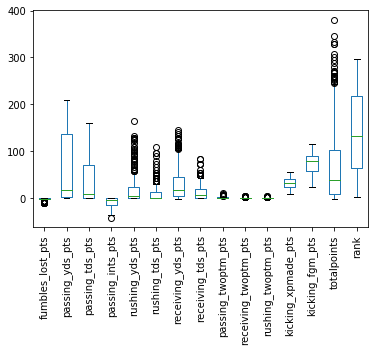

In [46]:
# Allow graphs to show in notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
nfl.plot(kind='box', rot = 90)
# Rank stands out at first because it's the most even.
# It seems like passing yards and passing touchdowns (tds) have big variance
# It looks like rushing yards, rushing tds, and receiving yards have the biggest outliers with fewer players running/catching the most
# Based on this chart, interceptions and two point conversions (twoptm) will likely have very little effect on player rank across the season

In [ ]:
# Look for correlations between variables
nfl.corr()
# looks like rushing yards, rushing tds, receivings yards are the strongest correlated with rank but they're negative

In [ ]:
#scatter plot total points v rank

In [ ]:
# Plot as Scatter Matrix Instead
pd.plotting.scatter_matrix(nfl[['fumbles_lost_pts', 'passing_yds_pts', 'passing_tds_pts', 'passing_ints_pts', 'rushing_yds_pts',
 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'passing_twoptm_pts', 'receiving_twoptm_pts', 'rushing_twoptm_pts',
 'kicking_xpmade_pts', 'kicking_fgm_pts', 'rank']], alpha=0.2, figsize=(10, 10), diagonal='kde')

# This is a very tiny matrix, I can't tell anything

In [ ]:
# Plot just the stronger correlated variables
pd.plotting.scatter_matrix(nfl[['rushing_yds_pts', 'rushing_tds_pts', 'receiving_yds_pts', 'receiving_tds_pts', 'rank']], alpha=0.7, figsize=(15, 15), diagonal='kde')
# Nothing appears to be correlated with rank directly
# But there are strong correlations between receiving yards/tds or rushing yards/tds

#### Modeling
I haven't learned much about rank yet using correlations so I moved on to modeling. I started with random forest to do a quick preliminary model that would also determine important features without having to do feature scaling.

In [ ]:
# create dataframe for nflmean
# create dataframe for nflzero
# create dataframe for nflmedian
# see if they're different

In [ ]:
# I filled in the blank cells with means from each column
# I tried to figure this out as a for loop but was unsuccessful

nfl.fumbles_lost_pts.fillna(nfl.fumbles_lost_pts.mean(),inplace = True)
nfl.passing_yds_pts.fillna(nfl.passing_yds_pts.mean(),inplace = True)
nfl.passing_tds_pts.fillna(nfl.passing_tds_pts.mean(),inplace = True)
nfl.passing_ints_pts.fillna(nfl.passing_ints_pts.mean(),inplace = True)
nfl.rushing_yds_pts.fillna(nfl.rushing_yds_pts.mean(),inplace = True)
nfl.rushing_tds_pts.fillna(nfl.rushing_tds_pts.mean(),inplace = True)
nfl.receiving_yds_pts.fillna(nfl.receiving_yds_pts.mean(),inplace = True)
nfl.receiving_tds_pts.fillna(nfl.receiving_tds_pts.mean(),inplace = True)
nfl.passing_twoptm_pts.fillna(nfl.passing_twoptm_pts.mean(),inplace = True)
nfl.receiving_twoptm_pts.fillna(nfl.receiving_twoptm_pts.mean(),inplace = True)
nfl.rushing_twoptm_pts.fillna(nfl.rushing_twoptm_pts.mean(),inplace = True)
nfl.kicking_xpmade_pts.fillna(nfl.kicking_xpmade_pts.mean(),inplace = True)
nfl.kicking_fgm_pts.fillna(nfl.kicking_fgm_pts.mean(),inplace = True)
nfl.head()

In [ ]:
# trying random forest
nfl.dropna(inplace = True)
nfl.shape
# Dropped 7 rows, probably bc player rank included some team defenses in the top 300

In [ ]:
#define X and y
feature_cols = nfl.columns.drop('rank')
feature_cols
X = nfl[feature_cols]
y = nfl['rank']

In [ ]:
# predicting rank with a Random Forest
import numpy as np
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

# list of values to try for n_estimators
estimator_range = range(10, 310, 10)
# 10 estimators, up to 300, in steps of 10

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
from sklearn.model_selection import cross_val_score
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

print RMSE_scores

In [ ]:
# write a loop to test cv values

In [ ]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')
# about 200 estimators seems like low RMSE

In [ ]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=60, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [ ]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')
# 7 or 11 features is good

In [ ]:
# show the best RMSE and the corresponding max_features
sorted(zip(RMSE_scores, feature_range))[0]
# but using all 13 is best

In [ ]:
# max_features=13 is best and n_estimators=200 
rfreg = RandomForestRegressor(n_estimators=200, max_features=10, oob_score=True, random_state=1)
rfreg.fit(X, y)

In [ ]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values('importance', ascending=False)
# looks like receiving yds and rushing yds are most important
# this makes sense since you have more of those spots available on your team

In [ ]:
# try again with only 5 features since apparently only 3 are important

In [ ]:
# starting with scatter plots and linreg lines for receiving and rushing yds
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

print sns.lmplot(x='receiving_yds_pts', y='rank', data=nfl, aspect=1.5, scatter_kws={'alpha':0.2})
print sns.lmplot(x='rushing_yds_pts', y='rank', data=nfl, aspect=1.5, scatter_kws={'alpha':0.2})
# well linear regression is not going to work

In [ ]:
# so lets look at logreg on receiving yds and rushing yds
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split

In [ ]:
feature_cols_imp = ['receiving_yds_pts', 'rushing_yds_pts']
Ximp = nfl[feature_cols_imp]
yimp = nfl['rank']

Ximp_tr, Ximp_te, yimp_tr, yimp_te = train_test_split(Ximp, yimp, random_state = 1)

logreg.fit(Ximp_tr, yimp_tr)
nfl_pred_class = logreg.predict(Ximp_tr)
print logreg.coef_.max()
# but who is it???

In [ ]:
# do logreg rmse
from sklearn.metrics import mean_squared_error
logregMSE = mean_squared_error(yimp_tr, nfl_pred_class)

logregRMSE = np.sqrt(logregMSE)
print logregRMSE

# then compare to null rmse
# create a NumPy array with the same shape as y_test
yimp_null = np.zeros_like(yimp_te, dtype=float)

# fill the array with the mean value of y_test
yimp_null.fill(yimp_te.mean())

nullRMSE = np.sqrt(mean_squared_error(yimp_te, yimp_null))
print nullRMSE
# pretty sure my error is much worse than null which means something is terribly wrong.

#### Future work
- See if I can predict improvement in players across years.  
- Split apart field goals into 3 and 5 points. For now, just scored all field goals made as 3 points since I did not want to loop through all kickers of each game across the entire season to determine which kicks were longer than others.
- Try to draft position rank besides positions (e.g. WR1, WR2)